# Ex. 4 Neural Networks Learning

## 1 Neural Neworks

## 1.1 Visualizing the data

In [113]:
# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from scipy.optimize import minimize # for minimizing the cost function

In [114]:
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
[m,n] = X.shape  
y = y.ravel() # turn y into a 1d array
# y[y == 10] = 0 # in the Coursara's course, 
               # character '0' was labeled as '10' for the convenience in MATLAB
               # here, I change it back to '0' for the convenience in Python
# convert each character label to a vector
Y = np.zeros((m,10))
for yi,Yi in zip(y,Y):
    Yi[yi-1] = 1.0
        
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)


In [3]:
from PIL import Image

def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
#     img = scipy.misc.toimage( big_picture )
    img = Image.fromarray(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    plt.xticks([])
    plt.yticks([])

    
def display1sample(X,y,nrow):
    """
    Display a single sample (row)
    """
    img = Image.fromarray(getDatumImg(X[nrow]))
    plt.imshow(img,cmap = cm.Greys_r)
    print(f'Labeled character is {y[nrow]}')

Labeled character is 10


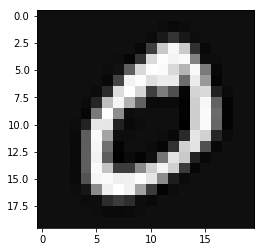

In [115]:
# Test the display functions
display1sample(X,y,0)

## 1.2 Model representation

In [301]:
weightmat = scipy.io.loadmat('data/ex4weights1.mat')

In [302]:
Theta1 = weightmat['Theta1'] # 25 by 401
Theta2 = weightmat['Theta2'] # 10 by 26

## 1.3 Feedforward the cost function

In [303]:
def H(theta1,theta2,X):
    
    """
        theta1,2: 2d array
        X: 2d of m by n
    """
    z2 = theta1 @ X.T # z2: 25 by m
    a2 = expit(z2) 
    a2 = np.insert(a2,0,1,axis=0) # a2: 26 by m
    z3 = theta2 @ a2 # z3: 10 by m
    a3 = expit(z3)
    
    return a3.T # return a 2d array of m by 10


def h(theta1,theta2,x):
    
    """
        theta1,2: 2d array
        x: 1d of n
    """    
    z2 = theta1 @ x
    a2 = expit(z2)
    a2 = np.insert(a2,0,1)
    z3 = theta2 @ a2
    a3 = expit(z3)
    
    return a3 # 1d array of 10

def forwardProg(thetalist,x):
    
    """
        thetalist: list of theta
    """
    a = []
    z = []
    a.append(x[1:]) # input layer
    for theta in thetalist:
        # propagate to next layer
        z.append(theta @ np.insert(a[-1],0,1))
        a.append(expit(z[-1]))
    
    return a[1:], z

In [304]:
h(Theta1,Theta2,X[1])

array([4.79026796e-04, 2.41495958e-03, 3.44755685e-03, 4.05616281e-05,
       6.53412433e-03, 1.75930169e-03, 1.15788527e-02, 2.39107046e-03,
       1.97025086e-03, 9.95696931e-01])

In [305]:
al, zl = forwardProg([Theta1,Theta2],X[1])

In [306]:
def costFunction(thetalist,X,Y):
    
    """
        Compute cost function without regularization
    """
    m = X.shape[0]
    # unvectorize
    mysum = 0
    for i in range(0,m):
        a, z = forwardProg(thetalist,X[i])
        term1 =  (- Y[i]) @ np.log(a[-1]) # a[-1] is last element of a, which is the output layer
        term2 = (1 - Y[i]) @ np.log(1 - a[-1])
        mysum += (term1 - term2)

    J = mysum / m    
    
    return J



In [307]:
def rgcostFunction(thetalist,X,Y,mylambda = 0):

    """
        Compute cost function with regularization
    """
    
    J0 = costFunction(thetalist,X,Y)
        
    rgterm = 0
    for theta in thetalist:
        rgterm += np.sum(np.square(theta[:,1:]))
    rgterm = rgterm * mylambda / (2 * X.shape[0])
    
    J = J0 + rgterm
    
    return J

In [308]:
costFunction([Theta1,Theta2],X,Y)

0.2876291651613188

In [309]:
rgcostFunction([Theta1,Theta2],X,Y,1)

0.38376985909092354

## 2 Backpropagation

### 2.1 Sigmoid gradient

In [14]:
# Sigmoid gradient

def sigmoidGradient(z):
    g = expit(z)
    grad = g * (1 - g)
    return grad

In [15]:
sigmoidGradient(10)

4.5395807735907655e-05

### 2.2 Random initialization

In [359]:
# These are some global variables I'm suing to ensure the sizes
# of various matrices are correct
#these are NOT including bias nits
# input_layer_size = 400
# hidden_layer_size = 25
# output_layer_size = 10

def randomInitialization(lsizelst,eps_ini = 0.12):
    """
    lsizelst is a list of which each elemeter is the size of each layer (excluding the bias unit)
    """
    
    [input_layer_size,hidden_layer_size,output_layer_size] = lsizelst 

    theta1 = np.random.random((hidden_layer_size,input_layer_size + 1 )) * 2 * eps_ini - eps_ini
    theta2 = np.random.random((output_layer_size,hidden_layer_size + 1 )) * 2 * eps_ini - eps_ini
    
    return [theta1,theta2]

In [360]:
aa = randomInitialization([400,25,10])
print(aa[0].shape,aa[1].shape)

(25, 401) (10, 26)


### 2.3 Backpropagation

In [18]:
# a[]: length of 2
# z[]: length of 2

In [274]:
def computeGradient(thetalist,X,Y):
    
    [theta1, theta2] = thetalist
    DELTA1 = np.zeros_like(theta1)
    DELTA2 = np.zeros_like(theta2)
    for i in range(X.shape[0]):
        alist, zlist = forwardProg(thetalist,X[i])   # alist, zlist are lists with length of 2
                                             # Here, a = [a2, a3],  z = [z2, z3]

        [a2,a3] = alist
        [z2,z3] = zlist
        a2 = np.insert(a2,0,1) # add the bias term ( +1 ) to the activation vectors
        a1 = X[i] # here X[i] already includes bias unit
        z2 = np.insert(z2,0,1)
        delta3 = a3 - Y[i] # 1d array of 10
        delta2 = (theta2.T @ delta3) * sigmoidGradient(z2)
        delta2 = delta2[1:]

        DELTA1 += delta2.reshape((-1,1)) @ a1.reshape((1,-1))
        DELTA2 += delta3.reshape((-1,1)) @ a2.reshape((1,-1))
       
    return DELTA1 / X.shape[0], DELTA2 / X.shape[0]

In [234]:
grad1, grad2 = gradient([theta1,theta2],X,Y)

In [236]:
grad2.shape

(10, 26)

In [81]:
def unroll(matrixlst):
    """
    unroll a matrix list (eg, theta list) to a long vector
    """
    length = 0
    vector = np.array([])
    for matrix in matrixlst:
        vector = np.concatenate((vector,matrix.ravel()))
    
    return vector

def roll(vector,lsizelst):
    """
    lsizelst is a list of which each elemeter is the size of each layer (excluding the bias unit)
    """
    ntheta = len(lsizelst) - 1
    matrixlst = []
#     for size1,size0 in zip(layersizelist[1:],layersizelist[:-1]):
    index = 0
    for i in range(ntheta):
        nrow = lsizelst[i+1]
        ncol = lsizelst[i]+1
        matrixlst.append(vector[index:index+nrow*ncol].reshape((nrow,ncol)))
#         print(matrixlst[i].shape)
        index += nrow*ncol
    return matrixlst

In [342]:
a = unroll([Theta1,Theta2])
a.shape

(10285,)

In [344]:
b = roll(a,[400,25,10])

In [345]:
b[0].shape

(25, 401)

### 2.4 Gradient Checking

In [277]:
def computeNumericalGradient(thetalist,X,Y,lsizelst):
    eps = 0.0001   
    vtheta = unroll(thetalist) # unroll the theta matrices to a long vector
    vnumgrad = np.zeros_like(vtheta) # vector of numerical gradient
    for i in range(vnumgrad.size):
        vthetaPlus = np.copy(vtheta)
        vthetaMinus = np.copy(vtheta)
        vthetaPlus[i] += eps
        vthetaMinus[i] -= eps
        JthetaPlus = costFunction(roll(vthetaPlus,lsizelst),X,Y) 
        JthetaMinus = costFunction(roll(vthetaMinus,lsizelst),X,Y)
        vnumgrad[i] = (JthetaPlus - JthetaMinus) / (2 * eps)

    return roll(vnumgrad,lsizelst)
        

In [272]:
def checkNNGradients(X,Y,ninput = 20,mtest = 20,nhidden = 15,ti = 0):
    """
    Use a fraction of input units (ie less features) and less hidden units to check the Gradient
    ntest: number of features (or input layer units, not including the bias unit)
    mtest: number of samples
    nhidden: number of hidden units
    ti: index of the first sample (better randomly choose one)
    """
    print("Checking Neural Networks gradients ...")
    print(f"Number of test input units: {ninput}")
    print(f"Number of test hidden units: {nhidden}")
    print(f"Use {mtest} samples, from {ti} to {ti + mtest - 1}")
    # starting index, better 
    Xtest = X[ti : ti + mtest,0 : ninput + 1]
    Ytest = Y[ti : ti + mtest]

    layer_size_list = [ninput,nhidden,10]
    [th1,th2] = randomInitialization(layer_size_list)
    [g1,g2] = computeGradient([th1,th2],Xtest,Ytest)
    [ng1,ng2] = computeNumericalGradient([th1,th2],Xtest,Ytest,layer_size_list)
    
    difference = np.abs(unroll([g1,g2]) - unroll([ng1,ng2])) # a long unrolled vector
    avediff = np.sum(difference) / difference.size # average difference between numerical gradient and backprog gradient
    maxdiff = np.max(difference)
    
    print("\nCheck Completed.")
    print(f"Average difference: {avediff}")
    print(f"Maximum difference: {maxdiff}")
    
    return avediff, maxdiff

In [273]:
checkNNGradients(X,Y,ninput = 20,mtest = 60,ti = 103)

Checking Neural Networks gradients ...
Number of test input units: 20
Number of test hidden units: 15
Use 60 samples, from 103 to 162

Check Completed.
Average difference: 1.391867642249423e-11
Maximum difference: 1.1661921428540722e-10


(1.391867642249423e-11, 1.1661921428540722e-10)

### 2.5 Regularized Neural Networks

In [331]:
def rgcomputeGradient(thetalist,X,Y,mylambda):
    
    gradlist = computeGradient(thetalist,X,Y)
    rggradlist = []
    for grad,theta in zip(gradlist,thetalist):
        rgterm = np.insert((mylambda / X.shape[0]) * theta[:,1:],0,0,axis=1)
        rggradlist.append(grad + rgterm)
        
    return rggradlist

In [317]:
def rgcomputeNumericalGradient(thetalist,X,Y,lsizelst,mylambda = 0):
    eps = 0.0001   
    vtheta = unroll(thetalist) # unroll the theta matrices to a long vector
    vnumgrad = np.zeros_like(vtheta) # vector of numerical gradient
    for i in range(vnumgrad.size):
        vthetaPlus = np.copy(vtheta)
        vthetaMinus = np.copy(vtheta)
        vthetaPlus[i] += eps
        vthetaMinus[i] -= eps
        JthetaPlus = rgcostFunction(roll(vthetaPlus,lsizelst),X,Y,mylambda) 
        JthetaMinus = rgcostFunction(roll(vthetaMinus,lsizelst),X,Y,mylambda)
        vnumgrad[i] = (JthetaPlus - JthetaMinus) / (2 * eps)

    return roll(vnumgrad,lsizelst)

In [326]:
def rgcheckNNGradients(X,Y,mylambda = 0,ninput = 20,mtest = 20,nhidden = 15,ti = 0):
    """
    Use a fraction of input units (ie less features) and less hidden units to check the Gradient
    ntest: number of features (or input layer units, not including the bias unit)
    mtest: number of samples
    nhidden: number of hidden units
    ti: index of the first sample (better randomly choose one)
    """
    print("Checking Neural Networks gradients ...")
    print(f"Number of test input units: {ninput}")
    print(f"Number of test hidden units: {nhidden}")
    print(f"Use {mtest} samples, from {ti} to {ti + mtest - 1}")
    # starting index, better 
    Xtest = X[ti : ti + mtest,0 : ninput + 1]
    Ytest = Y[ti : ti + mtest]

    layer_size_list = [ninput,nhidden,10]
    [th1,th2] = randomInitialization(layer_size_list)
    [g1,g2] = rgcomputeGradient([th1,th2],Xtest,Ytest,mylambda)
    [ng1,ng2] = rgcomputeNumericalGradient([th1,th2],Xtest,Ytest,layer_size_list,mylambda)
    
    difference = np.abs(unroll([g1,g2]) - unroll([ng1,ng2])) # a long unrolled vector
    avediff = np.sum(difference) / difference.size # average difference between numerical gradient and backprog gradient
    maxdiff = np.max(difference)
    
    print("\nCheck Completed.")
    print(f"Average difference: {avediff}")
    print(f"Maximum difference: {maxdiff}")
    
    return avediff, maxdiff

In [333]:
rgcheckNNGradients(X,Y,mylambda=0.1,ninput=30,mtest=20,ti=153)

Checking Neural Networks gradients ...
Number of test input units: 30
Number of test hidden units: 15
Use 20 samples, from 153 to 172

Check Completed.
Average difference: 4.024898492578232e-12
Maximum difference: 6.234229799062518e-11


(4.024898492578232e-12, 6.234229799062518e-11)

### 2.6 Learning parameters

In [371]:
def URrgcomputeGradient(vthetalist,X,Y,lsizelst,mylambda = 0):
    """
    UnRolled version of computeGradient,using a unrolled vector of thetalist as input
    """
    thetalist = roll(vthetalist,lsizelst)
    gradlist = rgcomputeGradient(thetalist,X,Y,mylambda)
    
    return unroll(gradlist)
    

def URrgcostFunction(vthetalist,X,Y,lsizelst,mylambda = 0):
    thetalist = roll(vthetalist,lsizelst)
    return rgcostFunction(thetalist,X,Y,mylambda)


In [394]:
def miniCost(theta0,X,Y,lsizelst,mylambda = .0,maxiter = 50):
    """
        minimizing the cost function
        theta0 must be a 1d array (obtained by unrolling the theta list)
    """
    
    result = minimize(URrgcostFunction, x0=theta0, args=(X,Y,lsizelst,mylambda), method='CG',
                      jac = URrgcomputeGradient, options={'maxiter':maxiter,'disp':True})

    return roll(result.x,lsizelst) # return the theta (1d array of n)

In [397]:
# Train
def LearnNN(X,Y,mylambda,layer_size_list = [400,25,10],maxiter = 50):
    print("Learning Neural Network parameters")
    print(f"lambda = {mylambda}, max iteration = {maxiter}")
    layer_size_list = [400,25,10]
    mylambda = 0.1
    theta0_lst = randomInitialization(layerSize)
#     print(f"theta1 shape: {theta0_lst[0].shape},theta2 shape: {theta0_lst[1].shape}" )
    vtheta0 = unroll(theta0_lst) # unroll the theta list to a long 1d array
    theta_mini = miniCost(vtheta0,X,Y,layer_size_list,mylambda,maxiter)
    print("Completed.")
    return theta_mini

In [398]:
THETA1 = LearnNN(X,Y,mylambda=0.1,maxiter=400)

Learning Neural Network parameters
lambda = 0.1, max iteration = 400
         Current function value: 0.071358
         Iterations: 400
         Function evaluations: 1135
         Gradient evaluations: 1135
Completed.


In [401]:
THETA2 = LearnNN(X,Y,mylambda=1,maxiter=400)

Learning Neural Network parameters
lambda = 1, max iteration = 400
         Current function value: 0.072896
         Iterations: 400
         Function evaluations: 1156
         Gradient evaluations: 1156
Completed.


In [424]:
THETA3 = LearnNN(X,Y,mylambda=0,maxiter=400)

Learning Neural Network parameters
lambda = 0, max iteration = 400
         Current function value: 0.068683
         Iterations: 400
         Function evaluations: 1164
         Gradient evaluations: 1164
Completed.


In [418]:
def predictNN(theta1,theta2,x):
    
    """
        use trained neural network parameters to predict (i.e. forward propagation)
    """
    z2 = theta1 @ x
    a2 = expit(z2) # here, a2 is a 1d array of 25
    a2 = np.insert(a2,0,1) # insert the bias unit
    
    z3 = theta2 @ a2
    a3 = expit(z3)
    
#     print(a3)
    prey = np.argmax(a3)+1
#     if prey == 10:
#         prey = 0
    return prey

# note: "0" has been labeled as 10 here, due to the MATLAB convenience in the homework
def ExamineNN(thetalist,X,y):
    [theta1, theta2] = thetalist
    ncorrect = 0
    nwrong = 0
    for xrow,yrow in zip(X,y):
        prey = predictNN(theta1,theta2,xrow)
        if prey == yrow:
            ncorrect += 1
        else:
            nwrong +=1
    print(f"accuracy = {ncorrect / y.size * 100:.2f} %")

In [425]:
ExamineNN(THETA3,X,y)

accuracy = 100.00 %


In [414]:
def checkresult(X,y,thetalist,nrow):
    img = Image.fromarray(getDatumImg(X[nrow]))
    plt.imshow(img,cmap = cm.Greys_r)
    prey = predictNN(thetalist[0],thetalist[1],X[nrow])
    print(prey)

2


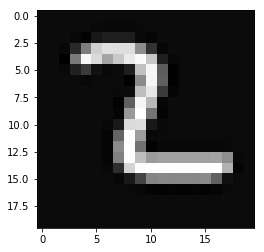

In [435]:
checkresult(X,y,THETA3,39)